# Predictive Model

The metrics that will be used to evaluate this stage are:

- **Diversity** of tasks (use of classification and regression) and of algorithms, this is, tested more than 4 with significantly different language bias OR with a significant number of variants.

- **Parameter Tuning**, with a systematic approach.

- **Understanding Algorithm Behavior**, solid (even if not deep) understanding of the behavior of most algorithms used OR <3 algorithms, also understanding the effect of parameters.

- Training and testing on properly separated data, with multiple splits.

- **Performance Estimation**, additional factors correctly taken into account (e.g. time), focus on performance measures aligned with DM goals and data characteristics, advanced performance measures (e.g. AUC), adequate baseline, correct analysis of values ​​for comparison, including tests of statistical significance, correct estimate of overfitting.

- **Model Improvement**, development guided by performance improvement goals, even if pedagogical goals have not been ignored.

- **Feature Importance**, correctly interpreted, related to the application domain.

- Analysis of "white box" models, correctly interpreted, related to the application domain

In [438]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import optuna
warnings.filterwarnings('ignore')

from sklearn.discriminant_analysis import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import cross_val_score
import time

BEST_HYPER_PARAMETERS = {
    "decision_tree": {'max_depth': 12, 'min_samples_split': 0.5852764228495217, 'min_samples_leaf': 12, 'max_features': 'log2', 'criterion': 'gini'},
    "svm": {'C': 4.714182255925566, 'kernel': 'sigmoid', 'gamma': 0.0019414173812153962, 'coef0': 0.1118685741584527, 'class_weight': None},
    "naive_bayes": {'var_smoothing': 4.57921912074695e-05},
    "random_forest": {'n_estimators': 104, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 11, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'absolute_error'},
    "knn": {'n_neighbors': 30, 'weights': 'distance', 'metric': 'manhattan', 'p': 2, 'algorithm': 'auto', 'leaf_size': 38, 'n_jobs': -1}
}

teams = pd.read_csv("data_prepared/teams.csv")

print(teams[['year','tmID','avg_per','awards_players','awards_coaches']])
# teams = teams[['year','tmID','playoff','confID','avg_pie','avg_per']]

label_encoder = LabelEncoder()

numerical_features = teams.select_dtypes(include=['float', 'int']).columns
numerical_features = numerical_features.drop('year')

scaler = StandardScaler()
teams[numerical_features] = scaler.fit_transform(teams[numerical_features])

teams['playoff'] = teams['playoff'].map({'Y': 1, 'N': 0})
teams['confID'] = teams['confID'].map({'EA': 0, 'WE': 1})

def encode_categorical_columns(df):
    for col in df.select_dtypes(include=['object']).columns:
        if col == 'playoff' or col == 'confID': continue
        else: df[col] = label_encoder.fit_transform(df[col])
    return df

encode_categorical_columns(teams)
teams = teams.fillna(0)

     year tmID    avg_per  awards_players  awards_coaches
0      10  ATL  19.527225               0               0
1      11  ATL  27.040398               1               1
2       2  CHA   0.000000               0               0
3       3  CHA  19.039025               0               0
4       4  CHA  19.166082               0               0
..    ...  ...        ...             ...             ...
136     7  WAS  18.293490               1               0
137     8  WAS  18.272193               0               0
138     9  WAS  21.910974               0               0
139    10  WAS  24.766599               0               0
140    11  WAS  19.499872               1               0

[141 rows x 5 columns]


In [439]:
def normalize_predictions(predictions):
    return (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))

def get_error(pred_proba, label_playoff):
    errors = []

    for pred, label in zip(pred_proba, label_playoff):
        errors.append(abs(pred - label))

    return sum(errors)

def get_train_and_test_data(data, year):
    train = data[data['year'] < year]
    test = data[data['year'] == year]

    train.drop("year", axis=1, inplace=True)
    test.drop("year", axis=1, inplace=True)

    X_train = train.drop("playoff", axis=1)
    Y_train = train["playoff"]

    X_test = test.drop("playoff", axis=1)
    Y_test = test["playoff"]

    return X_train, Y_train, X_test, Y_test

def run_model(model, data, year, number, only_df = False):

    X_train, Y_train, X_test, Y_test = get_train_and_test_data(data, year)
    
    start_timer = time.time()

    model.fit(X_train, Y_train)

    if isinstance(model, (LinearRegression, RandomForestRegressor)):
        y_pred = model.predict(X_test)
        y_pred_proba = normalize_predictions(y_pred)
    else:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    error = get_error(y_pred_proba, Y_test)

    y_pred = np.zeros_like(y_pred_proba) 
    top_indices = np.argsort(y_pred_proba)[-number:]
    y_pred[top_indices] = 1
    
    stop_timer = time.time()

    # build prediction df
    prediction_df = pd.DataFrame()
    prediction_df.loc[:, 'tmID'] = label_encoder.inverse_transform(X_test.loc[:, 'tmID'])
    prediction_df.loc[:, 'Playoff'] = y_pred_proba

    if only_df:
        return prediction_df

    prediction_df.loc[:, 'Playoff_Binary'] = y_pred
    prediction_df.loc[:, 'Playoff_Labeled'] = Y_test.values
    
    # statistics
    time_elapsed = stop_timer - start_timer
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)
    accuracy = accuracy_score(Y_test, y_pred)
    auc = roc_auc_score(Y_test, y_pred)

    return prediction_df, {
        "time": time_elapsed,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        "auc": auc,
        "error": error
    }

In [440]:
results_accuracy = {}
results_precision = {}
results_error = {}

def run_model_by_conferences(model, year):
    
    if year == 11:
        east_pred_df = run_model(model, teams[teams['confID'] == 0], year, 4, True)
        weast_pred_df = run_model(model, teams[teams['confID'] == 1], year, 4, True)
        pred_df = pd.concat([east_pred_df, weast_pred_df])
        pred_df['tmID'] = pred_df['tmID'].replace("DET", "TUL") # replace team that has different 'tmID' and 'franchID
        pred_df = pred_df.sort_values('tmID')
        prob = pred_df['Playoff']
        pred_df['Playoff'] = prob * (8 / prob.sum())
        pred_df['Playoff'] = pred_df['Playoff'].round(2)
        print(pred_df['Playoff'].sum())
        return pred_df

    east_pred_df, east_statistics = run_model(model, teams[teams['confID'] == 0], year, 4)
    weast_pred_df, weast_statistics = run_model(model, teams[teams['confID'] == 1], year, 4)

    statistics = {}

    for k in east_statistics.keys():
        statistics[k] = (east_statistics[k] + weast_statistics[k]) / 2
    
    print(pd.concat([east_pred_df, weast_pred_df]))
    print(f"Time: {statistics['time']:.3f}    Error: {statistics['error']:.2f}    Accuracy: {statistics['accuracy']:.2f}    Precision: {statistics['precision']:.2f}    Recall: {statistics['recall']:.2f}    F1: {statistics['f1']:.2f}    AUC: {statistics['auc']:.2f}")
    print()
    
    results_accuracy[str(model.__class__.__name__)] = statistics['accuracy']
    results_precision[str(model.__class__.__name__)] = statistics['precision']
    results_error[str(model.__class__.__name__)] = statistics['error']

## 1 - Algorithms

### 1.1 - Decision Tree

In [441]:
def decision_tree_objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    X_train, Y_train, _, _ = get_train_and_test_data(teams, 10)

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    score = cross_val_score(model, X_train, Y_train, cv=3, scoring='accuracy').mean()

    return 1 - score


study = optuna.create_study(direction='minimize')
study.optimize(decision_tree_objective, n_trials=50)

print("Best Hyperparameters:", study.best_params)

run_model_by_conferences(DecisionTreeClassifier(**study.best_params, random_state=42), 10)
run_model_by_conferences(DecisionTreeClassifier(**BEST_HYPER_PARAMETERS["decision_tree"], random_state=42), 10) # best hyper parameters

# predict test data with best hyper parameters
run_model_by_conferences(DecisionTreeClassifier(**BEST_HYPER_PARAMETERS["decision_tree"], random_state=42), 11)

[I 2024-12-09 22:55:06,976] A new study created in memory with name: no-name-f7bafefa-9aed-42ee-a170-e0d36e7cf925
[I 2024-12-09 22:55:06,992] Trial 0 finished with value: 0.43477282950967167 and parameters: {'max_depth': 5, 'min_samples_split': 0.6838212823082461, 'min_samples_leaf': 7, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.43477282950967167.
[I 2024-12-09 22:55:07,005] Trial 1 finished with value: 0.4170040485829959 and parameters: {'max_depth': 4, 'min_samples_split': 0.6771286100846157, 'min_samples_leaf': 19, 'max_features': None, 'criterion': 'gini'}. Best is trial 1 with value: 0.4170040485829959.
[I 2024-12-09 22:55:07,017] Trial 2 finished with value: 0.4786324786324786 and parameters: {'max_depth': 1, 'min_samples_split': 0.5008824372721031, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 1 with value: 0.4170040485829959.
[I 2024-12-09 22:55:07,030] Trial 3 finished with value: 0.4520917678812416 an

Best Hyperparameters: {'max_depth': 18, 'min_samples_split': 0.17019386553215798, 'min_samples_leaf': 12, 'max_features': 'log2', 'criterion': 'entropy'}
  tmID   Playoff  Playoff_Binary  Playoff_Labeled
0  ATL  0.500000             0.0              1.0
1  CHI  0.500000             0.0              0.0
2  CON  0.500000             0.0              0.0
3  DET  0.875000             1.0              1.0
4  IND  0.500000             1.0              1.0
5  NYL  0.875000             1.0              0.0
6  WAS  0.500000             1.0              1.0
0  HOU  0.142857             0.0              0.0
1  LAS  0.782609             1.0              1.0
2  MIN  0.142857             0.0              0.0
3  PHO  0.545455             0.0              1.0
4  SAC  0.782609             1.0              0.0
5  SAS  0.782609             1.0              1.0
6  SEA  0.782609             1.0              1.0
Time: 0.002    Error: 2.84    Accuracy: 0.71    Precision: 0.75    Recall: 0.75    F1: 0.75    A

,tmID,Playoff
0,ATL,0.52
1,CHI,0.52
2,CON,0.52
4,IND,0.76
0,LAS,0.99
1,MIN,0.16
5,NYL,0.52
2,PHO,0.99
3,SAS,0.99
4,SEA,0.99


### 1.2 - SVM

In [442]:
def svm_objective(trial):
    C = trial.suggest_loguniform('C', 1e-5, 1e2)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_loguniform('gamma', 1e-5, 1e1) if kernel in ['rbf', 'poly', 'sigmoid'] else 'scale'
    degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
    coef0 = trial.suggest_float('coef0', -1, 1) if kernel in ['poly', 'sigmoid'] else 0
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])

    X_train, Y_train, _, _ = get_train_and_test_data(teams, 10)

    model = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        degree=degree,
        coef0=coef0,
        class_weight=class_weight,
        random_state=42
    )

    score = cross_val_score(model, X_train, Y_train, cv=3, scoring='accuracy').mean()

    return 1 - score

study = optuna.create_study(direction='minimize')
study.optimize(svm_objective, n_trials=50)

print("Best Hyperparameters:", study.best_params)

run_model_by_conferences(SVC(**study.best_params, random_state=42, probability=True), 10)
run_model_by_conferences(SVC(**BEST_HYPER_PARAMETERS["svm"], random_state=42, probability=True), 10) # best hyper parameters

# predict test data with best hyper parameters
run_model_by_conferences(SVC(**BEST_HYPER_PARAMETERS["svm"], random_state=42, probability=True), 11)

[I 2024-12-09 22:55:07,940] A new study created in memory with name: no-name-15b60708-b0fc-4c24-9d5c-3fe9d1db7161
[I 2024-12-09 22:55:07,955] Trial 0 finished with value: 0.46896086369770584 and parameters: {'C': 8.641065811878624, 'kernel': 'sigmoid', 'gamma': 4.166112432706357, 'coef0': -0.3438232591655732, 'class_weight': None}. Best is trial 0 with value: 0.46896086369770584.
[I 2024-12-09 22:55:07,967] Trial 1 finished with value: 0.5125955915429599 and parameters: {'C': 0.00013964534946098064, 'kernel': 'poly', 'gamma': 6.321763055724733e-05, 'degree': 2, 'coef0': 0.06664035683925351, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.46896086369770584.
[I 2024-12-09 22:55:07,980] Trial 2 finished with value: 0.47750787224471436 and parameters: {'C': 2.7523650039536535e-05, 'kernel': 'sigmoid', 'gamma': 0.0010466463973743479, 'coef0': -0.615746382318886, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.46896086369770584.
[I 2024-12-09 22:55:07,992] Trial 3 finis

Best Hyperparameters: {'C': 0.032461046921540115, 'kernel': 'linear', 'class_weight': None}
  tmID   Playoff  Playoff_Binary  Playoff_Labeled
0  ATL  0.611506             1.0              1.0
1  CHI  0.598733             1.0              0.0
2  CON  0.581688             0.0              0.0
3  DET  0.558706             0.0              1.0
4  IND  0.593397             1.0              1.0
5  NYL  0.584531             0.0              0.0
6  WAS  0.589120             1.0              1.0
0  HOU  0.284140             0.0              0.0
1  LAS  0.397542             0.0              1.0
2  MIN  0.471710             0.0              0.0
3  PHO  0.557942             1.0              1.0
4  SAC  0.500000             1.0              0.0
5  SAS  0.561590             1.0              1.0
6  SEA  0.708157             1.0              1.0
Time: 0.003    Error: 3.22    Accuracy: 0.71    Precision: 0.75    Recall: 0.75    F1: 0.75    AUC: 0.71

  tmID   Playoff  Playoff_Binary  Playoff_Labeled
0 

,tmID,Playoff
0,ATL,0.64
1,CHI,0.62
2,CON,0.59
4,IND,0.58
0,LAS,0.81
1,MIN,0.50
5,NYL,0.64
2,PHO,0.95
3,SAS,0.74
4,SEA,0.79


### 1.3 - KNeighborsClassifier

In [443]:
# def knn_objective(trial):
#     # Define the hyperparameter search space for KNN Classifier
#     n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
#     weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
#     metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
#     p = trial.suggest_int('p', 1, 2)  # p for Minkowski distance
#     algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])
#     leaf_size = trial.suggest_int('leaf_size', 10, 40)
#     n_jobs = trial.suggest_categorical('n_jobs', [-1])  # Use all processors

#     X_train, Y_train, _, _ = get_train_and_test_data(teams, 10)

#     model = KNeighborsClassifier(
#         n_neighbors=n_neighbors,
#         weights=weights,
#         metric=metric,
#         p=p,
#         algorithm=algorithm,
#         leaf_size=leaf_size,
#         n_jobs=n_jobs
#     )

#     score = cross_val_score(model, X_train, Y_train, cv=3, scoring='accuracy').mean()

#     return score

# study = optuna.create_study(direction='maximize')
# study.optimize(knn_objective, n_trials=50)

# print("Best Hyperparameters:", study.best_params)

# run_model_by_conferences(KNeighborsClassifier(**study.best_params), 10)
# run_model_by_conferences(KNeighborsClassifier(**BEST_HYPER_PARAMETERS["knn"]), 10) # best hyper parameters
#
# # predict test data with best hyper parameters with best hyper parameters
# run_model_by_conferences(KNeighborsClassifier(**BEST_HYPER_PARAMETERS["knn"]), 11) # best hyper parameters

### 1.4 - Naive Bayes

In [444]:
def naive_bayes_objective(trial):
    var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-9, 1e-2)

    X_train, Y_train, _, _ = get_train_and_test_data(teams, 10)

    model = GaussianNB(
        var_smoothing=var_smoothing
    )

    score = cross_val_score(model, X_train, Y_train, cv=3, scoring='accuracy').mean()

    return 1 - score

study = optuna.create_study(direction='minimize')
study.optimize(naive_bayes_objective, n_trials=50)

print("Best Hyperparameters:", study.best_params)

run_model_by_conferences(GaussianNB(**study.best_params), 10)
run_model_by_conferences(GaussianNB(**BEST_HYPER_PARAMETERS["naive_bayes"]), 10) # best hyper parameters

# predict test data with best hyper parameters with best hyper parameters
run_model_by_conferences(GaussianNB(**BEST_HYPER_PARAMETERS["naive_bayes"]), 11)

[I 2024-12-09 22:55:08,899] A new study created in memory with name: no-name-250ce163-97ea-494f-9e32-869ea915a881
[I 2024-12-09 22:55:08,919] Trial 0 finished with value: 0.39923526765632034 and parameters: {'var_smoothing': 1.0864444486663216e-07}. Best is trial 0 with value: 0.39923526765632034.
[I 2024-12-09 22:55:08,930] Trial 1 finished with value: 0.39923526765632034 and parameters: {'var_smoothing': 2.500679456568439e-06}. Best is trial 0 with value: 0.39923526765632034.
[I 2024-12-09 22:55:08,941] Trial 2 finished with value: 0.39923526765632034 and parameters: {'var_smoothing': 1.1783966778896534e-08}. Best is trial 0 with value: 0.39923526765632034.
[I 2024-12-09 22:55:08,953] Trial 3 finished with value: 0.39923526765632034 and parameters: {'var_smoothing': 7.15000179382362e-08}. Best is trial 0 with value: 0.39923526765632034.
[I 2024-12-09 22:55:08,965] Trial 4 finished with value: 0.39946018893387314 and parameters: {'var_smoothing': 0.0030811643489927153}. Best is trial 

Best Hyperparameters: {'var_smoothing': 2.514845158991823e-05}
  tmID       Playoff  Playoff_Binary  Playoff_Labeled
0  ATL  4.398988e-10             0.0              1.0
1  CHI  4.406030e-01             0.0              0.0
2  CON  9.999994e-01             1.0              0.0
3  DET  1.000000e+00             1.0              1.0
4  IND  9.966068e-01             1.0              1.0
5  NYL  9.999453e-01             1.0              0.0
6  WAS  2.660335e-02             0.0              1.0
0  HOU  1.373658e-02             0.0              0.0
1  LAS  1.556014e-06             0.0              1.0
2  MIN  9.339538e-02             1.0              0.0
3  PHO  6.394741e-06             0.0              1.0
4  SAC  9.821268e-01             1.0              0.0
5  SAS  9.999998e-01             1.0              1.0
6  SEA  9.999999e-01             1.0              1.0
Time: 0.002    Error: 3.75    Accuracy: 0.43    Precision: 0.50    Recall: 0.50    F1: 0.50    AUC: 0.42

  tmID       Playoff 

,tmID,Playoff
0,ATL,0.81
1,CHI,0.25
2,CON,0.48
4,IND,0.81
0,LAS,0.81
1,MIN,0.01
5,NYL,0.81
2,PHO,0.81
3,SAS,0.81
4,SEA,0.81


### 1.5 - Random Forest

In [445]:
def random_forest_objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])  # Removed 'auto'
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    criterion = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error'])

    X_train, Y_train, _, _ = get_train_and_test_data(teams, 10)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        criterion=criterion,
        random_state=42
    )

    score = cross_val_score(model, X_train, Y_train, cv=3, scoring='neg_mean_squared_error').mean()

    return score

study = optuna.create_study(direction='maximize')
study.optimize(random_forest_objective, n_trials=50)

print("Best Hyperparameters:", study.best_params)

run_model_by_conferences(RandomForestRegressor(**study.best_params, random_state=42), 10)
run_model_by_conferences(RandomForestRegressor(**BEST_HYPER_PARAMETERS["random_forest"], random_state=42), 10) # best hyper parameters

# predict test data with best hyper parameters
run_model_by_conferences(RandomForestRegressor(**BEST_HYPER_PARAMETERS["random_forest"], random_state=42), 11)

[I 2024-12-09 22:55:09,591] A new study created in memory with name: no-name-3f6db229-b38b-41ec-80a4-3952228b2625
[I 2024-12-09 22:55:10,750] Trial 0 finished with value: -0.34686036747000143 and parameters: {'n_estimators': 170, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': False, 'criterion': 'absolute_error'}. Best is trial 0 with value: -0.34686036747000143.
[I 2024-12-09 22:55:10,952] Trial 1 finished with value: -0.23098227529854795 and parameters: {'n_estimators': 164, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'squared_error'}. Best is trial 1 with value: -0.23098227529854795.
[I 2024-12-09 22:55:11,015] Trial 2 finished with value: -0.24811551956815117 and parameters: {'n_estimators': 25, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': True, 'criterion': 'absolute_error'}. Best is trial 1 with value:

Best Hyperparameters: {'n_estimators': 140, 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'absolute_error'}
  tmID   Playoff  Playoff_Binary  Playoff_Labeled
0  ATL  0.000000             0.0              1.0
1  CHI  0.800000             1.0              0.0
2  CON  1.000000             1.0              0.0
3  DET  0.876923             1.0              1.0
4  IND  0.769231             0.0              1.0
5  NYL  0.876923             1.0              0.0
6  WAS  0.507692             0.0              1.0
0  HOU  0.019608             0.0              0.0
1  LAS  0.352941             1.0              1.0
2  MIN  0.000000             0.0              0.0
3  PHO  0.019608             0.0              1.0
4  SAC  0.686275             1.0              0.0
5  SAS  0.745098             1.0              1.0
6  SEA  1.000000             1.0              1.0
Time: 0.078    Error: 3.56    Accuracy: 0.43    Precision: 0.50    

,tmID,Playoff
0,ATL,0.77
1,CHI,0.77
2,CON,0.23
4,IND,0.99
0,LAS,1.01
1,MIN,0.00
5,NYL,0.00
2,PHO,0.86
3,SAS,0.53
4,SEA,1.08


### 1.7 - Linear Regression

In [446]:
run_model_by_conferences(LinearRegression(), 10)

# predict test data with best hyper parameters
run_model_by_conferences(LinearRegression(), 11)

  tmID   Playoff  Playoff_Binary  Playoff_Labeled
0  ATL  0.894411             1.0              1.0
1  CHI  0.678273             1.0              0.0
2  CON  0.114006             0.0              0.0
3  DET  0.669778             1.0              1.0
4  IND  0.516767             0.0              1.0
5  NYL  0.000000             0.0              0.0
6  WAS  1.000000             1.0              1.0
0  HOU  0.358439             0.0              0.0
1  LAS  0.000000             0.0              1.0
2  MIN  0.459739             1.0              0.0
3  PHO  0.653667             1.0              1.0
4  SAC  0.333961             0.0              0.0
5  SAS  0.478787             1.0              1.0
6  SEA  1.000000             1.0              1.0
Time: 0.002    Error: 2.37    Accuracy: 0.71    Precision: 0.75    Recall: 0.75    F1: 0.75    AUC: 0.71

8.03


,tmID,Playoff
0,ATL,0.11
1,CHI,0.13
2,CON,0.07
4,IND,0.00
0,LAS,0.80
1,MIN,0.00
5,NYL,2.32
2,PHO,1.72
3,SAS,0.37
4,SEA,2.32


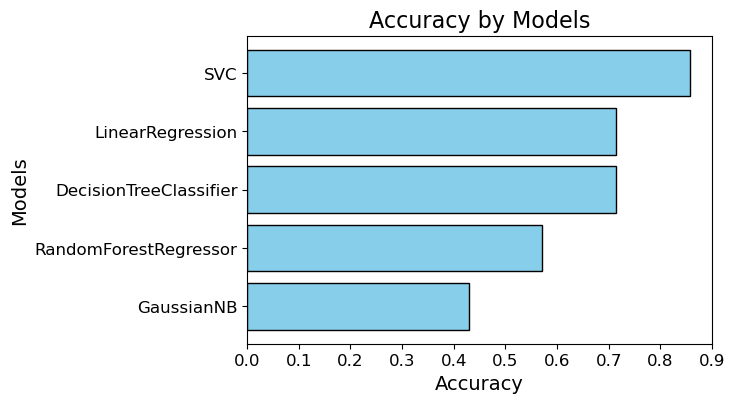

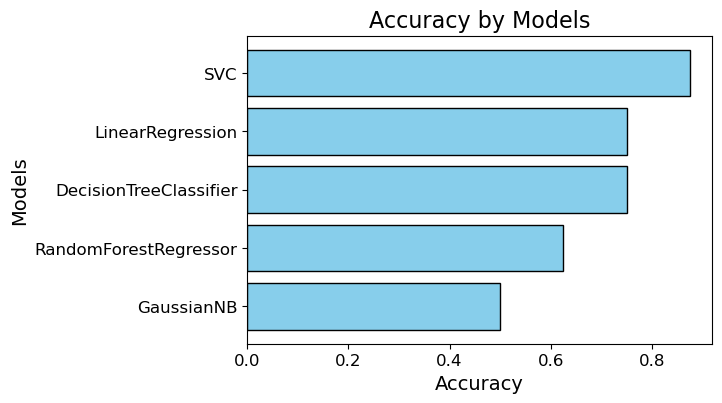

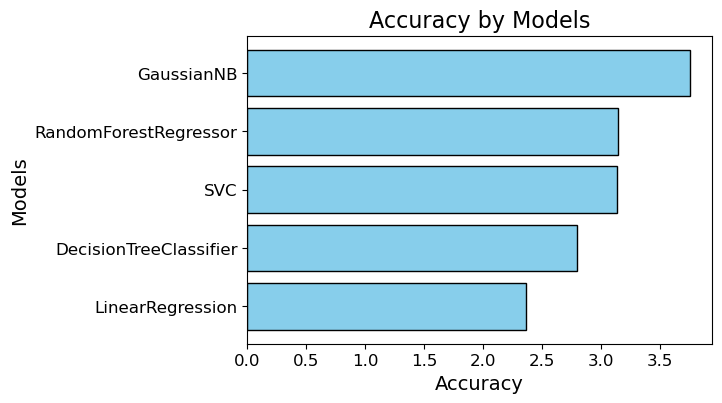

In [447]:
def show_statistic_figure(statistic_name, statistic_results):
    labels = list(statistic_results.keys())
    values = list(statistic_results.values())

    plt.figure(figsize=(6, 4))
    plt.barh(labels, values, color='skyblue', edgecolor='black')
    plt.title("Accuracy by Models", fontsize=16)
    plt.xlabel("Accuracy", fontsize=14)
    plt.ylabel("Models", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


results_accuracy = dict(sorted(results_accuracy.items(), key=lambda item: item[1]))
results_precision = dict(sorted(results_precision.items(), key=lambda item: item[1]))
results_error = dict(sorted(results_error.items(), key=lambda item: item[1]))

show_statistic_figure("Accuracy", results_accuracy)
show_statistic_figure("Precision", results_precision)
show_statistic_figure("Error", results_error)

In [448]:
BEST_MODELS = {
    "decision_tree": run_model_by_conferences(DecisionTreeClassifier(**BEST_HYPER_PARAMETERS["decision_tree"], random_state=42), 11),
    "svm": run_model_by_conferences(SVC(**BEST_HYPER_PARAMETERS["svm"], random_state=42, probability=True), 11),
    # "knn": run_model_by_conferences(KNeighborsClassifier(**BEST_HYPER_PARAMETERS["knn"]), 11),
    "naive_bayes": run_model_by_conferences(GaussianNB(**BEST_HYPER_PARAMETERS["naive_bayes"]), 11),
    "random_forest": run_model_by_conferences(RandomForestRegressor(**BEST_HYPER_PARAMETERS["random_forest"], random_state=42), 11),
    "linear_regression": run_model_by_conferences(LinearRegression(), 11)
}

os.makedirs('data_prediction', exist_ok=True)
path = os.path.join('data_prediction', 'G44.csv')
BEST_MODELS['linear_regression'].to_csv(path, index=False) # escolher aqui o modelo

for k,v in BEST_MODELS.items():
    v.to_csv(os.path.join('data_prediction', k+'.csv'), index=False)


8.0
8.0
8.030000000000003
8.0
8.03
